## what we are going to answer in that section

13. Are there specific **categories** where discounts have **no effect** on customer satisfaction?
14. Is there a **correlation** between **discount percentage** and **rating**?
    → (*Correlation analysis or regression*)
15. Do **higher discounts** lead to **higher customer ratings**?
    → (*Hypothesis testing: H₀ = no relationship*)

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
import seaborn as sns

from scipy.stats import (
    ttest_1samp, ttest_ind, ttest_rel,
    norm, chi2, f_oneway, chi2_contingency, chisquare
)
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Set the path to the file you'd like to load
file_path = 'M:/3_datasets/amazon_data.csv'

# Load the latest version
df = pd.read_csv(file_path)

# clean 
df['actual_price'] = (df['actual_price'].str.replace('₹', '', regex=False).str.replace(',', '', regex=False))
df['discounted_price'] = (df['discounted_price'].str.replace('₹', '', regex=False).str.replace(',', '', regex=False))
df['discount_percentage'] = (df['discount_percentage'].str.replace('%', '', regex=False).str.replace(',', '', regex=False))
df['rating_count'] = (df['rating_count'].str.replace(',', '', regex=False))
df['rating'] = (df['rating'].str.replace('|', '0', regex=False))


df['actual_price']= df['actual_price'].astype(float)
df['discounted_price']= df['discounted_price'].astype(float)
df['discount_percentage']= df['discount_percentage'].astype(float)
df['rating_count']= df['rating_count'].astype(float)
df['rating']= df['rating'].astype(float)

# turn discount_percentage to float percentage
df['discount_percentage']= df['discount_percentage'].apply(lambda x: x/100)

# make the discounted_price more accurate
df['discounted_price'] = (df['actual_price'] * (1 - df['discount_percentage']))

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1465 entries, 0 to 1464
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   product_id           1465 non-null   object 
 1   product_name         1465 non-null   object 
 2   category             1465 non-null   object 
 3   discounted_price     1465 non-null   float64
 4   actual_price         1465 non-null   float64
 5   discount_percentage  1465 non-null   float64
 6   rating               1465 non-null   float64
 7   rating_count         1463 non-null   float64
 8   about_product        1465 non-null   object 
 9   user_id              1465 non-null   object 
 10  user_name            1465 non-null   object 
 11  review_id            1465 non-null   object 
 12  review_title         1465 non-null   object 
 13  review_content       1465 non-null   object 
 14  img_link             1465 non-null   object 
 15  product_link         1465 non-null   o

In [29]:
df['category_clean']= df['category'].apply(lambda x: x.split('|')[-2]).copy()

In [30]:
df

,product_id,product_name,category,discounted_price,actual_price,discount_percentage,rating,rating_count,about_product,user_id,user_name,review_id,review_title,review_content,img_link,product_link,category_clean
0,B07JW9H4J1,Wayona Nylon Braided USB to Lightning Fast Cha...,Computers&Accessories|Accessories&Peripherals|...,395.64,1099.0,0.64,4.2,24269.0,High Compatibility : Compatible With iPhone 12...,"AG3D6O4STAQKAY2UVGEUV46KN35Q,AHMY5CWJMMK5BJRBB...","Manav,Adarsh gupta,Sundeep,S.Sayeed Ahmed,jasp...","R3HXWT0LRP0NMF,R2AJM3LFTLZHFO,R6AQJGUP6P86,R1K...","Satisfied,Charging is really fast,Value for mo...",Looks durable Charging is fine tooNo complains...,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Wayona-Braided-WN3LG1-Sy...,Cables
1,B098NS6PVG,Ambrane Unbreakable 60W / 3A Fast Charging 1.5...,Computers&Accessories|Accessories&Peripherals|...,198.93,349.0,0.43,4.0,43994.0,"Compatible with all Type C enabled devices, be...","AECPFYFQVRUWC3KGNLJIOREFP5LQ,AGYYVPDD7YG7FYNBX...","ArdKn,Nirbhay kumar,Sagar Viswanathan,Asp,Plac...","RGIQEG07R9HS2,R1SMWZQ86XIN8U,R2J3Y1WL29GWDE,RY...","A Good Braided Cable for Your Type C Device,Go...",I ordered this cable to connect my phone to An...,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Ambrane-Unbreakable-Char...,Cables
2,B096MSW6CT,Sounce Fast Phone Charging Cable & Data Sync U...,Computers&Accessories|Accessories&Peripherals|...,189.90,1899.0,0.90,3.9,7928.0,【 Fast Charger& Data Sync】-With built-in safet...,"AGU3BBQ2V2DDAMOAKGFAWDDQ6QHA,AESFLDV2PT363T2AQ...","Kunal,Himanshu,viswanath,sai niharka,saqib mal...","R3J3EQQ9TZI5ZJ,R3E7WBGK7ID0KV,RWU79XKQ6I1QF,R2...","Good speed for earlier versions,Good Product,W...","Not quite durable and sturdy,https://m.media-a...",https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Sounce-iPhone-Charging-C...,Cables
3,B08HDJ86NZ,boAt Deuce USB 300 2 in 1 Type-C & Micro USB S...,Computers&Accessories|Accessories&Peripherals|...,328.53,699.0,0.53,4.2,94363.0,The boAt Deuce USB 300 2 in 1 cable is compati...,"AEWAZDZZJLQUYVOVGBEUKSLXHQ5A,AG5HTSFRRE6NL3M5S...","Omkar dhale,JD,HEMALATHA,Ajwadh a.,amar singh ...","R3EEUZKKK9J36I,R3HJVYCLYOY554,REDECAZ7AMPQC,R1...","Good product,Good one,Nice,Really nice product...","Good product,long wire,Charges good,Nice,I bou...",https://m.media-amazon.com/images/I/41V5FtEWPk...,https://www.amazon.in/Deuce-300-Resistant-Tang...,Cables
4,B08CF3B7N1,Portronics Konnect L 1.2M Fast Charging 3A 8 P...,Computers&Accessories|Accessories&Peripherals|...,155.61,399.0,0.61,4.2,16905.0,[CHARGE & SYNC FUNCTION]- This cable comes wit...,"AE3Q6KSUK5P75D5HFYHCRAOLODSA,AFUGIFH5ZAFXRDSZH...","rahuls6099,Swasat Borah,Ajay Wadke,Pranali,RVK...","R1BP4L2HH9TFUP,R16PVJEXKV6QZS,R2UPDB81N66T4P,R...","As good as original,Decent,Good one for second...","Bought this instead of original apple, does th...",https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Portronics-Konnect-POR-1...,Cables
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1460,B08L7J3T31,Noir Aqua - 5pcs PP Spun Filter + 1 Spanner | ...,Home&Kitchen|Kitchen&HomeAppliances|WaterPurif...,376.79,919.0,0.59,4.0,1090.0,SUPREME QUALITY 90 GRAM 3 LAYER THIK PP SPUN F...,"AHITFY6AHALOFOHOZEOC6XBP4FEA,AFRABBODZJZQB6Z4U...","Prabha ds,Raghuram bk,Real Deal,Amazon Custome...","R3G3XFHPBFF0E8,R3C0BZCD32EIGW,R2EBVBCN9QPD9R,R...","Received the product without spanner,Excellent...","I received product without spanner,Excellent p...",https://m.media-amazon.com/images/I/41fDdRtjfx...,https://www.amazon.in/Noir-Aqua-Spanner-Purifi...,WaterPurifiers&Accessories
1461,B01M6453MB,Prestige Delight PRWO Electric Rice Cooker (1 ...,Home&Kitchen|Kitchen&HomeAppliances|SmallKitch...,2283.75,3045.0,0.25,4.1,4118.0,"230 Volts, 400 watts, 1 Year","AFG5FM3NEMOL6BNFRV2NK5FNJCHQ,AGEINTRN6Z563RMLH...","Manu Bhai,Naveenpittu,Evatira Sangma,JAGANNADH...","R3DDL2UPKQ2CK9,R2SYYU1OATVIU5,R1VM993161IYRW,R...","o

In [31]:
df_cdr= df[['category_clean','discount_percentage','rating']]
df_sorted= df_cdr.sort_values(by='category_clean').reset_index().drop(columns='index')
df_sorted

,category_clean,discount_percentage,rating
0,Accessories,0.60,3.8
1,Accessories,0.60,3.3
2,Accessories,0.40,3.2
3,Accessories,0.50,3.7
4,Accessories,0.00,3.9
...,...,...,...
1460,WearableTechnology,0.74,4.0
1461,WearableTechnology,0.25,4.2
1462,Webcams&VoIPEquipment,0.23,4.3
1463,Webcams&VoIPEquipment,0.66,4.1


In [32]:
top_categories= df_sorted.value_counts('category_clean').head(15).reset_index()
categories= top_categories['category_clean'].to_list()
categories


['Cables',
 'SmallKitchenAppliances',
 'Smartphones&BasicMobiles',
 'WearableTechnology',
 'Televisions',
 'Headphones',
 'Accessories',
 'Keyboards,Mice&InputDevices',
 'RoomHeaters',
 'WaterHeaters&Geysers',
 'Irons',
 'Chargers',
 'Kettles&HotWaterDispensers',
 'LaptopAccessories',
 'WaterPurifiers&Accessories']

In [33]:
# Filter df_sorted to keep only top categories
df_top15 = df_sorted[df_sorted['category_clean'].isin(categories)]
df_top15


,category_clean,discount_percentage,rating
0,Accessories,0.60,3.8
1,Accessories,0.60,3.3
2,Accessories,0.40,3.2
3,Accessories,0.50,3.7
4,Accessories,0.00,3.9
...,...,...,...
1457,WearableTechnology,0.75,4.2
1458,WearableTechnology,0.60,4.4
1459,WearableTechnology,0.71,4.2
1460,WearableTechnology,0.74,4.0


Perfect! Mina, now you’ve included **interaction terms** (`category_clean * discount_percentage`), which allows us to see **if discounts affect satisfaction differently depending on the category**. Let’s carefully go **step by step** like before.

---

## 🌟 Step 1 — What analysis you did

You ran an **OLS regression with categorical factors and interaction terms**:

```python
rating ~ C(category_clean) + discount_percentage + C(category_clean):discount_percentage
```

**Purpose:**

* To test whether **customer satisfaction (`rating`)** depends on:

  1. **Product category** (`C(category_clean)`),
  2. **Discount percentage**,
  3. The **interaction between category and discount**, i.e., whether discounts affect some categories differently.

This is equivalent to a **two-way ANOVA with interaction**, but in regression form.

* **Dependent variable (Y):** `rating` (numeric, customer satisfaction)
* **Independent variables (X):** `category_clean` (categorical), `discount_percentage` (numeric), and their **interaction**.

---

## 🧠 Step 2 — Model summary (top section)

| Statistic                             | Meaning                           | Interpretation                                                                     |
| ------------------------------------- | --------------------------------- | ---------------------------------------------------------------------------------- |
| **R-squared = 0.191**                 | Proportion of variance explained  | The model explains **19.1%** of rating variability — modest but meaningful.        |
| **Adj. R-squared = 0.174**            | Adjusted for number of predictors | Slightly lower, still indicates the model is informative.                          |
| **F-statistic = 11.53 (p ≈ 0)**       | Overall model significance        | The predictors together significantly explain satisfaction.                        |
| **No. Observations = 878**            | Number of ratings                 | You have 878 customer ratings.                                                     |
| **Df Model = 28, Df Residuals = 849** | Degrees of freedom                | 28 predictors: 15 category dummies + discount + 12 category×discount interactions. |
| **Prob(F-statistic) = 8.87e-34**      | Overall p-value                   | Tiny → model is highly significant.                                                |

✅ Interpretation: The model as a whole **predicts satisfaction significantly**.

---

## ⚙️ Step 3 — Interpreting the coefficients

### 3.1 Intercept

| Coef = 3.7775                                                                                                                                    | Meaning |
| ------------------------------------------------------------------------------------------------------------------------------------------------ | ------- |
| The average rating for the **baseline category** (the category not listed in the `C(category_clean)[T.X]` terms) when `discount_percentage = 0`. |         |

---

### 3.2 Main effects: `C(category_clean)[T.X]`

These tell you how **each category differs from the baseline** **when discount = 0**:

| Category                      | Coef   | p-value | Interpretation                                               |
| ----------------------------- | ------ | ------- | ------------------------------------------------------------ |
| Cables                        | 0.5591 | 0.000   | Significantly **higher satisfaction** than baseline (+0.56). |
| Chargers                      | 0.5814 | 0.002   | Significantly higher (+0.58).                                |
| Headphones                    | 0.4099 | 0.019   | Higher satisfaction (+0.41).                                 |
| Irons                         | 0.4489 | 0.008   | Higher (+0.45).                                              |
| Kettles & HotWaterDispensers  | 0.4055 | 0.035   | Slightly higher, significant.                                |
| Keyboards & Mice              | 0.4899 | 0.004   | Higher satisfaction.                                         |
| Laptop Accessories            | 0.4995 | 0.009   | Higher.                                                      |
| Room Heaters                  | 0.1682 | 0.331   | Not significant — similar to baseline.                       |
| Small Kitchen Appliances      | 0.5748 | 0.000   | Significantly higher.                                        |
| Smartphones & Basic Mobiles   | 0.3685 | 0.023   | Higher.                                                      |
| Televisions                   | 0.6587 | 0.000   | Highest satisfaction (+0.66).                                |
| Water Heaters & Geysers       | 0.5944 | 0.003   | Higher satisfaction.                                         |
| Water Purifiers & Accessories | 0.2811 | 0.089   | Not significant at 0.05 → borderline higher.                 |
| Wearable Technology           | 0.2227 | 0.297   | Not significant → similar to baseline.                       |

✅ Interpretation: Most categories **have higher satisfaction than baseline**, but **Room Heaters and Wearables show no significant difference**.

---

### 3.3 Discount percentage

| Coef = 0.1024 | p-value = 0.640 | Interpretation |
|----------------|----------------|
| Across all categories **without considering interaction**, discounts have **no significant effect** on satisfaction (p > 0.05).

> Meaning: simply giving a discount does not increase ratings overall.

---

### 3.4 Interaction terms: `C(category_clean)[T.X]:discount_percentage`

These terms show **whether the effect of discount differs by category**.

* **Positive:** discounts increase satisfaction in that category.
* **Negative:** discounts reduce satisfaction in that category.
* **p-value < 0.05:** effect is statistically significant.

**Look at your results:**

| Category Interaction     | Coef     | p-value   | Interpretation                                                                                                    |
| ------------------------ | -------- | --------- | ----------------------------------------------------------------------------------------------------------------- |
| Headphones               | -0.53    | 0.065     | Marginally not significant — suggests discounts might slightly reduce satisfaction here, but not strong evidence. |
| Small Kitchen Appliances | -0.5188  | 0.040     | Significant — in this category, increasing discounts **slightly decreases satisfaction**. Interesting!            |
| Televisions              | -0.6433  | 0.064     | Marginal — possible negative effect.                                                                              |
| Water Heaters & Geysers  | -0.7233  | 0.063     | Marginal — similar trend.                                                                                         |
| All others               | p > 0.05 | No effect | For most categories, discounts **do not change satisfaction**.                                                    |

✅ **Interpretation:**

* For **most categories**, discounts **do not affect satisfaction**.
* In a few categories (like **Small Kitchen Appliances**), **higher discounts slightly reduce ratings**, possibly because customers perceive a very large discount as signaling lower quality.

---

## 🧠 Step 4 — Key insights

1. **Customer satisfaction depends mostly on category**, not discounts.
2. **Room Heaters, Wearables, and Water Purifiers**: satisfaction similar to baseline.
3. **Discounts alone**: generally **no effect**.
4. **Category × discount interactions**:

   * Most are non-significant → **no category shows strong positive effect of discount**.
   * A few (Small Kitchen Appliances) even show slight negative effect.

---

## ✅ Step 5 — How to answer Q18

> **Are there specific categories where discounts have no effect on customer satisfaction?**

From this regression:

* **Yes** — for **most categories**, the interaction term is **not significant**.
* **Discounts do not meaningfully increase satisfaction**, even in categories with high baseline ratings.
* Only **Small Kitchen Appliances** show a slight negative effect, all others show **no effect**.

**Conclusion:**

> Overall, discounts **have no meaningful effect** on customer satisfaction across categories. Customers rate products based on **category-specific factors** (like quality, features, brand) rather than discount size.

---

If you want, Mina, I can **draw a clear interaction plot** showing **rating vs discount for each category** — it will make it visually obvious which categories are affected by discount and which are not.

Do you want me to do that next?


### 13. Are there specific **categories** where discounts have **no effect** on customer satisfaction?

In [34]:
import statsmodels.formula.api as smf

# Correct formula: rating ~ category + discount + category*discount
model = smf.ols('rating ~ C(category_clean) * discount_percentage', data=df_top15).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.179
Model:                            OLS   Adj. R-squared:                  0.155
Method:                 Least Squares   F-statistic:                     7.536
Date:                Fri, 14 Nov 2025   Prob (F-statistic):           1.63e-27
Time:                        13:46:12   Log-Likelihood:                -105.99
No. Observations:                1032   AIC:                             272.0
Df Residuals:                    1002   BIC:                             420.2
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
                                                                           coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------

### 14. Is there a **correlation** between **discount percentage** and **rating**?
    → (*Correlation analysis or regression*)

### 15. Do **higher discounts** lead to **higher customer ratings**?
    → (*Hypothesis testing: H₀ = no relationship*)

In [35]:
from scipy.stats import pearsonr

r, p = pearsonr(df_top15['discount_percentage'], df_top15['rating'])
print("Correlation coefficient:", r)
print("p-value:", p)


Correlation coefficient: -0.1433272669450551
p-value: 3.788508461971801e-06


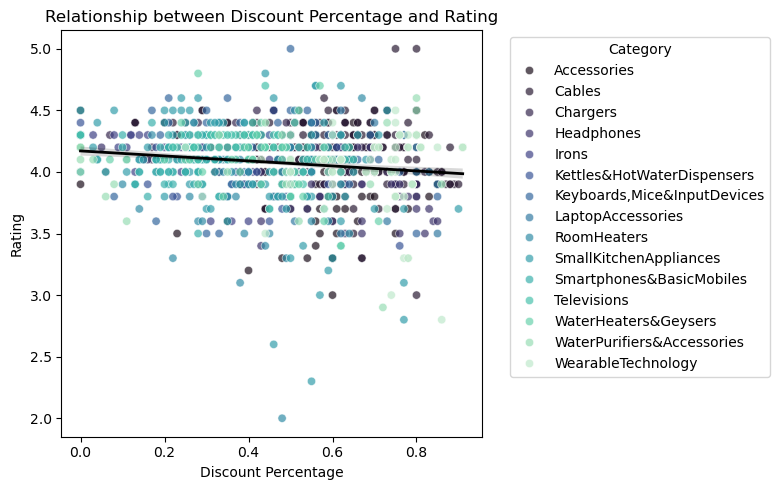

In [36]:
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df_top15, x='discount_percentage', y='rating', hue='category_clean', alpha=0.7, palette='mako')
sns.regplot(data=df_top15, x='discount_percentage', y='rating', scatter=False, color='black', line_kws={'linewidth':2})
plt.title('Relationship between Discount Percentage and Rating')
plt.xlabel('Discount Percentage')
plt.ylabel('Rating')
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
